In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform,randint
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_11043/948834685.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('../data/crawling_preprocess_data.csv',sep = ',')

In [3]:
pd.options.display.max_columns = None
data.head(5)

,Tournament,Phase,Home Team,Away Team,Match Date,Team Points,Team Two Pointers Made,Team Two Pointers Attempted,Team Three Pointers Made,Team Three Pointers Attempted,Team Free Throws Made,Team Free Throws Attempted,Team Offensive Rebounds,Team Defensive Rebounds,Team Total Rebounds,Team Assists,Team Steals,Team Blocks,Team Turnovers,Team Personal Fouls,Opponent Points,Opponent Two Pointers Made,Opponent Two Pointers Attempted,Opponent Three Pointers Made,Opponent Three Pointers Attempted,Opponent Free Throws Made,Opponent Free Throws Attempted,Opponent Offensive Rebounds,Opponent Defensive Rebounds,Opponent Total Rebounds,Opponent Assists,Opponent Steals,Opponent Blocks,Opponent Turnovers,Opponent Personal Fouls,Team,Opponent Team,Team Result,Winner Team,teamFGA,teamFGM,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamPoss,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,teamFIC,teamOrtg,opptFGA,opptFGM,opptPoss,teamDrtg,teamEDiff,team_Game_Score,Team Performance Index,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,oppt_Game_Score,Opponent Performance Index,Points difference,Finals,Last 32,Playoffs,Quarter-Finals,Regular Season,Semifinals,Top 16
0,Liga ACB,Regular Season,FC BARCELONA BÀSQUET,SASKI BASKONIA,2014-10-04,87.0,34.0,54.0,10.0,13.0,9.0,12.0,5.0,29.0,34.0,15.0,10.0,2.0,22.0,17.0,65.0,28.0,66.0,1.0,10.0,8.0,12.0,9.0,16.0,25.0,14.0,16.0,2.0,14.0,19.0,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,67.0,44.0,57.627119,34.090909,60.182623,73.134328,23.809524,76.315789,23.334748,87.940476,11.371328,2.274266,3.030303,1.298507,52.380952,15.194489,0.681818,0.454545,55.500,98.930554,76.0,29.0,82.889211,78.417926,20.512627,61.8,102.0,42.372881,48.275862,39.985236,38.815789,23.684211,76.190476,14.693535,19.302874,2.412859,3.703704,0.855263,33.000,78.417926,98.930554,-20.512627,35.802469,14.181524,1.000000,1.142857,38.5,64.0,22.0,0,0,0,0,1,0,0
1,Liga ACB,Regular Season,REAL BETIS BALONCESTO,CB 1939 CANARIAS,2014-10-04,87.0,33.0,66.0,8.0,18.0,13.0,19.0,8.0,23.0,31.0,13.0,8.0,1.0,13.0,27.0,96.0,35.0,63.0,8.0,20.0,18.0,30.0,10.0,25.0,35.0,24.0,8.0,1.0,12.0,19.0,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,84.0,41.0,46.969697,31.707317,47.098311,53.571429,24.242424,69.696970,12.338648,93.446061,8.561089,1.070136,1.587302,1.035714,46.067416,12.790240,1.000000,0.615385,37.625,93.101838,83.0,43.0,94.030303,102.094747,-8.992909,48.7,80.0,53.030303,55.813953,49.896050,56.626506,30.303030,75.757576,11.090573,8.507896,1.063487,1.515152,1.156627,62.750,102.094747,93.101838,8.992909,50.588235,22.684310,2.000000,0.666667,70.7,129.0,-9.0,0,0,0,0,1,0,0
2,Liga ACB,Regular Season,OBRADOIRO CAB,BÀSQUET MANRESA,2014-10-04,88.0,28.0,51.0,11.0,21.0,21.0,22.0,5.0,24.0,29.0,22.0,8.0,3.0,16.0,24.0,64.0,21.0,56.0,4.0,15.0,18.0,24.0,14.0,14.0,28.0,6.0,6.0,2.0,16.0,20.0,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,72.0,39.0,50.877193,56.410256,53.868756,61.805556,26.315789,63.157895,16.380016,87.507895,9.142032,3.428262,5.357143,1.222222,46.987952,21.929825,1.375000,0.500000,53.750,100.562355,71.0,25.0,78.466316,81.563661,18.998694,63.4,105.0,49.122807,24.000000,39.234919,38.028169,36.842105,73.684211,16.400164,7.646593,2.548864,3.921569,0.901408,14.250,81.563661,100.562355,-18.998694,34.246575,7.278020,0.375000,0.375000,23.5,59.0,24.0,0,0,0,0,1,0,0
3,Liga ACB,Regular Season,BILBAO BASKET,BALONCESTO FUENLABRADA,2014-10-05,73.0,24.0,59.0,7.0,25.0,18.0,23.0,10.0,23.0,33.0,15.0,9.0,2.0,10.0,23.0,54.0,18.0,60.0,2.0,22.0,16.0,23.0,14.0,21.0,35.0,8.0,5.0,0.0,13.0,22.0,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,84.0,31.0,48.529412,48.387097,38.780280,41.071429,32.258065,62.162162,9.604303,84.906452,10.599901,2.355534,3.333333,0.869048,36.904762,15.169903,1.500000,0.900000,33.125,85.976977,82.0,20.0,79.098378,68.269415,17.707562,40.2,79.0,51.470588,40.000000,2

In [4]:
data["Tournament"].unique()

array(['Liga ACB', 'Basket League', 'Eurocup', 'Euroleague'], dtype=object)

# Teams as Dummy Variables

In [5]:
baseline_data = data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]]
baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Liga ACB,2014-10-04,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,Regular Season
1,Liga ACB,2014-10-04,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,Regular Season
2,Liga ACB,2014-10-04,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,Regular Season
3,Liga ACB,2014-10-05,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,Regular Season
4,Liga ACB,2014-10-05,CB ESTUDIANTES,GIPUZKOA BASKET,1,CB ESTUDIANTES,Regular Season


## Greek Basket League 

In [6]:
greek_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Basket League'].reset_index(drop = True)
greek_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Basket League,2014-10-12,P.A.O.K. BC,RETHYMNO CRETAN KINGS B.C.,1,P.A.O.K. BC,Regular Season
1,Basket League,2014-10-12,PANIONIOS F.C.,KOLOSSOS RODOU B.C.,0,KOLOSSOS RODOU B.C.,Regular Season
2,Basket League,2014-10-12,G.S. LAVRIO B.C.,ARIS B.C.,0,ARIS B.C.,Regular Season
3,Basket League,2014-10-12,PANATHINAIKOS B.C.,NEA KIFISSIA B.C.,1,PANATHINAIKOS B.C.,Regular Season
4,Basket League,2014-10-12,OLYMPIACOS B.C.,APOLLON PATRAS B.C.,1,OLYMPIACOS B.C.,Regular Season


In [7]:
greece_home = pd.get_dummies(greek_baseline_data["Home Team"]).reset_index(drop = True)
greece_away = -1*pd.get_dummies(greek_baseline_data["Away Team"]).reset_index(drop = True)
greece_x = pd.concat([greece_home,greece_away],axis=1).groupby(level=0, axis=1).sum()
greece_y = greek_baseline_data["Team Result"]

/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_11043/3440212682.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  greece_x = pd.concat([greece_home,greece_away],axis=1).groupby(level=0, axis=1).sum()


In [8]:
x_train_greece=greece_x.iloc[:len(greek_baseline_data[greek_baseline_data["Match Date"]<"2018-08-01"])]
y_train_greece=greece_y.iloc[:len(greek_baseline_data[greek_baseline_data["Match Date"]<"2018-08-01"])]
x_test_greece=greece_x.iloc[len(greek_baseline_data[greek_baseline_data["Match Date"]<"2018-08-01"]):]
y_test_greece=greece_y.iloc[len(greek_baseline_data[greek_baseline_data["Match Date"]<"2018-08-01"]):]

In [9]:
x_train_greece.shape

(823, 22)

###  Logistic Regression

In [36]:
lgr = LogisticRegression(C = 0.3839820885947254,penalty = 'l1', solver= 'liblinear').fit(x_train_greece, y_train_greece)
y_pre_proba_lgr=lgr.predict_proba(x_test_greece)
print("Logistic Regression")
print()
bs_lgr = brier_score_loss(y_test_greece,y_pre_proba_lgr[:,1])
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
acc_lgr = accuracy_score(y_pre_lgr,y_test_greece)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_greece),3))
print()
f1_lgr=f1_score(y_pre_lgr,y_test_greece)
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_greece),3))


Logistic Regression

Test BS: 0.17

Test Accuracy: 0.738

Test F1-score: 0.8


In [11]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],greece_x.columns.values):
    coef_dict[feat] = coef
coef1=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef1=coef1.iloc[(-coef1[0].abs()).argsort()].reset_index()

In [12]:
sorted_coef1

,index,0
0,OLYMPIACOS B.C.,3.470640
1,PANATHINAIKOS B.C.,3.297892
2,AEK B.C.,1.252174
3,P.A.O.K. BC,1.061373
4,ARIS B.C.,0.939492
5,PANIONIOS F.C.,-0.822071
6,DOXA LEFKADAS B.C.,-0.735554
7,KAVALA,-0.527726
8,TRIKALA B.C.,-0.360224
9,PROMITHEAS PATRAS B.C.,0.358448


In [13]:
lgr.intercept_

array([0.78464279])

## Random Forest Classifier

In [37]:
rfc = RandomForestClassifier(max_depth= 38, max_features='sqrt', min_samples_leaf=0.0022712801155358453,
                             min_samples_split=0.009889030194338, n_estimators=53
                             ,random_state= 1).fit(x_train_greece, y_train_greece)

y_pre_proba_rfc=rfc.predict_proba(x_test_greece)
print("Random Forest Classifier")
print()
bs_rfc = brier_score_loss(y_test_greece,y_pre_proba_rfc[:,1])
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(pd.Series(y_pre_proba_rfc[:,1])>0.5,1,0)
acc_rfc = accuracy_score(y_pre_rfc,y_test_greece)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc,y_test_greece),3))
print()
f1_rfc = f1_score(y_pre_rfc,y_test_greece)
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_greece),3))

Random Forest Classifier

Test BS: 0.175

Test Accuracy: 0.728

Test F1-score: 0.792


In [15]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),greece_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,OLYMPIACOS B.C.,0.246405
1,PANATHINAIKOS B.C.,0.232781
2,AEK B.C.,0.050223
3,PANIONIOS F.C.,0.049719
4,TRIKALA B.C.,0.044849
5,P.A.O.K. BC,0.043859
6,KOROIVOS B.C.,0.037423
7,ARIS B.C.,0.035957
8,NEA KIFISSIA B.C.,0.034411
9,APOLLON PATRAS B.C.,0.032334


## xgboost

In [38]:
alg = XGBClassifier(colsample_bytree = 0.7120387144249468, gamma = 1.173482282705095, learning_rate = 0.18114216198386113,
                    max_depth= 41, n_estimators= 88, reg_lambda= 0.33962213881868086, subsample= 0.16627201904949962, 
                    objective='binary:logistic').fit(x_train_greece, y_train_greece)




y_pre_proba_alg=alg.predict_proba(x_test_greece)
print("xgboost")
print()
bs_xgb = brier_score_loss(y_test_greece,y_pre_proba_alg[:,1])
print("Test BS:",round(brier_score_loss(y_test_greece,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(pd.Series(y_pre_proba_alg[:,1])>0.5,1,0)
acc_xgb = accuracy_score(y_pre_alg,y_test_greece)
print("Test Accuracy:",round(accuracy_score(y_pre_alg,y_test_greece),3))
print()

f1_xgb = f1_score(y_pre_alg,y_test_greece)
print("Test F1-score:",round(f1_xgb,3))


xgboost

Test BS: 0.179

Test Accuracy: 0.728

Test F1-score: 0.788


In [17]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),greece_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,DOXA LEFKADAS B.C.,0.089006
1,OLYMPIACOS B.C.,0.075329
2,PANATHINAIKOS B.C.,0.075250
3,ARIS B.C.,0.063973
4,P.A.O.K. BC,0.060591
5,TRIKALA B.C.,0.059466
6,PANIONIOS F.C.,0.058942
7,APOLLON PATRAS B.C.,0.056584
8,AEK B.C.,0.056195
9,PROMITHEAS PATRAS B.C.,0.055180


# Ensemble

In [31]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3

def print_ens(e_prob,y_test):
    print("------Ensemble 3 classifier-------")
    print("Test BS:",round(brier_score_loss(y_test,e_prob),3))
    print()
    y_pre_ens=np.where(pd.Series(e_prob)>0.5,1,0)
    print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test),3))
    print()
    print("Test F1-score:",round(f1_score(y_pre_ens,y_test),3))

print_ens(ens_proba,y_test_greece)
          
# print()
# print("Test BS:",round(brier_score_loss(y_test_greece,ens_proba),3))
# print()
# y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
# print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_greece),3))
# print()
# print("Test F1-score:",round(f1_score(y_pre_ens,y_test_greece),3))


------Ensemble 3 classifier-------
Test BS: 0.172

Test Accuracy: 0.733

Test F1-score: 0.797


# start of my section
krev


In [44]:
## krev ensemble:
probs_lgr = y_pre_proba_lgr[:,1]
probs_rfc = y_pre_proba_rfc[:,1]
probs_xgb = y_pre_proba_alg[:,1]

# Equal priors or based on validation scores

# all of these give the same result
# raw_weights = [f1_rfc, f1_xgb, f1_lgr]  # Adjust these based on your model validation scores
# raw_weights = [acc_rfc, acc_xgb, acc_lgr]  
# raw_weights = [1, 1, 1]  
raw_weights = [bs_rfc, bs_xgb, bs_lgr]

weights = [weight / sum(raw_weights) for weight in raw_weights]
print(weights)


bayesian_ensemble_proba = weights[0] * probs_rfc + weights[1] * probs_xgb + weights[2] * probs_lgr

print_ens(bayesian_ensemble_proba,y_test_greece)


[0.33395616337341627, 0.3417574389354109, 0.3242863976911729]
------Ensemble 3 classifier-------
Test BS: 0.172

Test Accuracy: 0.733

Test F1-score: 0.797


In [5]:
import numpy as np
import pymc as pm
# import theano.tensor as tt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# import theano
# theano.config.optimizer = 'None'



ImportError: cannot import name 'np_version_under1p17' from 'pandas.compat.numpy' (/Users/kaylahuang/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pandas/compat/numpy/__init__.py)

In [ ]:
with pm.Model() as model:
    # Priors for model weights
    weights = pm.Dirichlet('weights', a=np.array([1., 1., 1.]))  # Uniform priors for simplicity

    # Model predictions as deterministic functions of weights and individual model predictions
    model_prediction = pm.Deterministic('prediction', weights[0] * probs_rfc + 
                                                     weights[1] * probs_xgb + 
                                                     weights[2] * probs_lgr)

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('obs', p=model_prediction, observed=y_test)

    # Posterior distribution
    trace = pm.sample(2000, return_inferencedata=False)

# View the trace summary to inspect model performance and weight values
print(pm.summary(trace))


# end of my section

In [26]:
pd.options.display.max_rows = None
see_final_g=greek_baseline_data[["Home Team","Away Team","Team Result","Winner Team"]][greek_baseline_data["Match Date"]>"2018-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,Winner Team,prediction probability,RPS
830,RETHYMNO CRETAN KINGS B.C.,G.S. LAVRIO B.C.,0,G.S. LAVRIO B.C.,0.748542,0.560315
834,PROMITHEAS PATRAS B.C.,PERISTERI B.C.,0,PERISTERI B.C.,0.741247,0.549448
841,PANIONIOS F.C.,ARIS B.C.,1,PANIONIOS F.C.,0.251770,0.559849
847,KYMIS B.C.,PERISTERI B.C.,0,PERISTERI B.C.,0.730516,0.533654
864,ARIS B.C.,PERISTERI B.C.,0,PERISTERI B.C.,0.883989,0.781436
876,KYMIS B.C.,HOLARGOS B.C.,0,HOLARGOS B.C.,0.730516,0.533654
888,ARIS B.C.,HOLARGOS B.C.,0,HOLARGOS B.C.,0.883989,0.781436
896,RETHYMNO CRETAN KINGS B.C.,GYMNASTIKOS S. LARISSAS 1928 B.C.,0,GYMNASTIKOS S. LARISSAS 1928 B.C.,0.786145,0.618023
923,KOLOSSOS RODOU B.C.,HOLARGOS B.C.,0,HOLARGOS B.C.,0.740760,0.548726
931,HOLARGOS B.C.,PERISTERI B.C.,0,PERISTERI B.C.,0.740811,0.548801


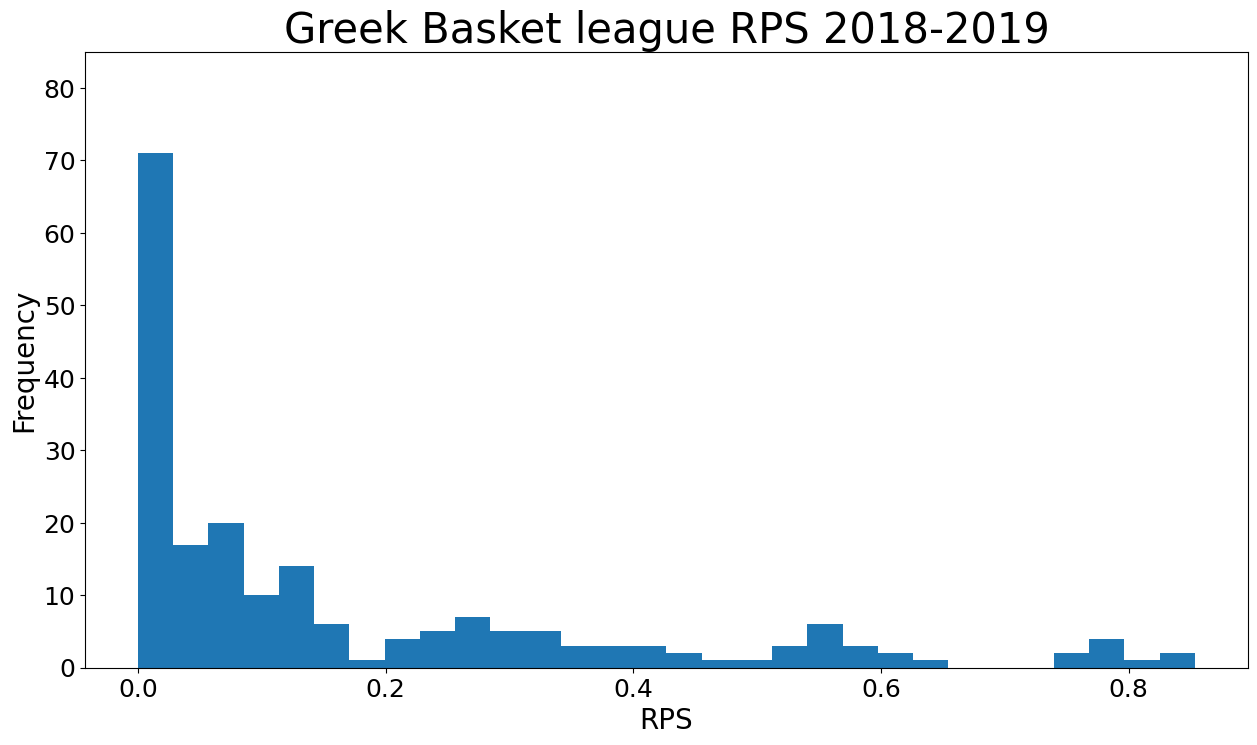

In [27]:
plt.figure(figsize=(15,8))



plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Greek Basket league RPS 2018-2019',fontsize=30)
plt.ylim(0,85)
plt.show()

In [21]:
greece_match_ups = greek_baseline_data[["Home Team","Away Team","Match Date","Winner Team"]][(greek_baseline_data["Match Date"]>'2018-08-01') & (greek_baseline_data["Tournament"]=='Basket League') & (greek_baseline_data["Phase"] == "Regular Season")]
greece_match_ups["Probability"] = ens_proba[:len(greece_match_ups)]
greece_match_ups["Winner Prediction"] = np.where(greece_match_ups["Probability"]>0.5,greece_match_ups["Home Team"],greece_match_ups["Away Team"])
greece_match_ups.head()

,Home Team,Away Team,Match Date,Winner Team,Probability,Winner Prediction
823,P.A.O.K. BC,RETHYMNO CRETAN KINGS B.C.,2018-10-06,P.A.O.K. BC,0.841146,P.A.O.K. BC
824,KOLOSSOS RODOU B.C.,PROMITHEAS PATRAS B.C.,2018-10-06,PROMITHEAS PATRAS B.C.,0.623038,KOLOSSOS RODOU B.C.
825,PANATHINAIKOS B.C.,GYMNASTIKOS S. LARISSAS 1928 B.C.,2018-10-06,PANATHINAIKOS B.C.,0.984290,PANATHINAIKOS B.C.
826,PERISTERI B.C.,AEK B.C.,2018-10-06,PERISTERI B.C.,0.394730,AEK B.C.
827,PANIONIOS F.C.,KYMIS B.C.,2018-10-07,KYMIS B.C.,0.465248,KYMIS B.C.


In [22]:
pd.crosstab(index=greece_match_ups["Winner Prediction"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Prediction,
OLYMPIACOS B.C.,24
PANATHINAIKOS B.C.,24
AEK B.C.,19
P.A.O.K. BC,18
ARIS B.C.,14
RETHYMNO CRETAN KINGS B.C.,12
KYMIS B.C.,11
PROMITHEAS PATRAS B.C.,11
HOLARGOS B.C.,10


In [23]:
pd.crosstab(index=greece_match_ups["Winner Team"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Team,
OLYMPIACOS B.C.,23
PANATHINAIKOS B.C.,23
AEK B.C.,18
PERISTERI B.C.,17
PROMITHEAS PATRAS B.C.,16
P.A.O.K. BC,15
GYMNASTIKOS S. LARISSAS 1928 B.C.,13
HOLARGOS B.C.,12
ARIS B.C.,8


# Liga ACB

In [24]:
spain_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Liga ACB'].reset_index(drop = True)
spain_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Liga ACB,2014-10-04,FC BARCELONA BÀSQUET,SASKI BASKONIA,1,FC BARCELONA BÀSQUET,Regular Season
1,Liga ACB,2014-10-04,REAL BETIS BALONCESTO,CB 1939 CANARIAS,0,CB 1939 CANARIAS,Regular Season
2,Liga ACB,2014-10-04,OBRADOIRO CAB,BÀSQUET MANRESA,1,OBRADOIRO CAB,Regular Season
3,Liga ACB,2014-10-05,BILBAO BASKET,BALONCESTO FUENLABRADA,1,BILBAO BASKET,Regular Season
4,Liga ACB,2014-10-05,CB ESTUDIANTES,GIPUZKOA BASKET,1,CB ESTUDIANTES,Regular Season


In [25]:
spain_home = pd.get_dummies(spain_baseline_data["Home Team"]).reset_index(drop = True)
spain_away = -1*pd.get_dummies(spain_baseline_data["Away Team"]).reset_index(drop = True)
spain_x = pd.concat([spain_home,spain_away],axis=1).groupby(level=0, axis=1).sum()
spain_y = spain_baseline_data["Team Result"]

In [26]:
spain_x.head()

,BALONCESTO FUENLABRADA,BALONCESTO MÁLAGA,BASKET ZARAGOZA,BC ANDORRA,BILBAO BASKET,BÀSQUET MANRESA,CB 1939 CANARIAS,CB BREOGÁN,CB ESTUDIANTES,CB GRAN CANARIA,CB MIRAFLORES,CLUB JOVENTUT BADALONA,FC BARCELONA BÀSQUET,GIPUZKOA BASKET,OBRADOIRO CAB,REAL BETIS BALONCESTO,REAL MADRID BALONCESTO,SASKI BASKONIA,UCAM MURCIA CB,VALENCIA BASKET
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-1,0,0
1,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,-1,0,0,0,0,0,0


In [27]:
x_train_spain=spain_x.iloc[:len(spain_baseline_data[spain_baseline_data["Match Date"]<"2018-08-01"])]
y_train_spain=spain_y.iloc[:len(spain_baseline_data[spain_baseline_data["Match Date"]<"2018-08-01"])]
x_test_spain=spain_x.iloc[len(spain_baseline_data[spain_baseline_data["Match Date"]<"2018-08-01"]):]
y_test_spain=spain_y.iloc[len(spain_baseline_data[spain_baseline_data["Match Date"]<"2018-08-01"]):]

###  Logistic Regression

In [28]:
lgr = LogisticRegression(solver='liblinear',C = 0.6783123387183132, penalty = 'l1').fit(x_train_spain, y_train_spain)
y_pre_proba_lgr=lgr.predict_proba(x_test_spain)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_spain),3))


Logistic Regression

Test BS: 0.202

Test Accuracy: 0.698

Test F1-score: 0.775


In [29]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],spain_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()

In [30]:
sorted_coef2

,index,0
0,REAL MADRID BALONCESTO,2.040238
1,FC BARCELONA BÀSQUET,1.377979
2,VALENCIA BASKET,1.258467
3,SASKI BASKONIA,1.104021
4,BALONCESTO MÁLAGA,0.862244
5,BÀSQUET MANRESA,-0.795799
6,CB GRAN CANARIA,0.698676
7,GIPUZKOA BASKET,-0.619168
8,REAL BETIS BALONCESTO,-0.527934
9,CB 1939 CANARIAS,0.444787


In [31]:
lgr.intercept_

array([0.67369568])

## Random Forest Classifier

In [32]:
rfc = RandomForestClassifier(max_depth= 39, max_features='sqrt', min_samples_leaf=0.0009330471732301171,
                             min_samples_split=0.075312968832076, n_estimators=73,
                             random_state=1).fit(x_train_spain, y_train_spain)

y_pre_proba_rfc=rfc.predict_proba(x_test_spain)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(pd.Series(y_pre_proba_rfc[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_spain),3))

Random Forest Classifier

Test BS: 0.209

Test Accuracy: 0.66

Test F1-score: 0.75


In [33]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),spain_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,REAL MADRID BALONCESTO,0.230570
1,BÀSQUET MANRESA,0.095743
2,FC BARCELONA BÀSQUET,0.088510
3,VALENCIA BASKET,0.086600
4,GIPUZKOA BASKET,0.085931
5,REAL BETIS BALONCESTO,0.078812
6,SASKI BASKONIA,0.059575
7,BALONCESTO MÁLAGA,0.040637
8,BASKET ZARAGOZA,0.030185
9,BALONCESTO FUENLABRADA,0.025963


## xgboost

In [34]:
alg = XGBClassifier(colsample_bytree= 0.6188949028768943, gamma= 2.819830261508139, learning_rate= 0.36256801131990146,
                    max_depth= 21, n_estimators= 86, reg_lambda= 0.09211406347716067, subsample= 0.5079441274104476,
                    objective='binary:logistic').fit(x_train_spain, y_train_spain)

y_pre_proba_alg=alg.predict_proba(x_test_spain)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(pd.Series(y_pre_proba_alg[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_spain),4))


xgboost

Test BS: 0.209

Test Accuracy: 0.667

Test F1-score: 0.7429


In [35]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),spain_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,REAL MADRID BALONCESTO,0.086151
1,VALENCIA BASKET,0.070338
2,UCAM MURCIA CB,0.065796
3,FC BARCELONA BÀSQUET,0.061315
4,BALONCESTO MÁLAGA,0.059471
5,CB ESTUDIANTES,0.055234
6,GIPUZKOA BASKET,0.054827
7,CB GRAN CANARIA,0.054645
8,SASKI BASKONIA,0.054412
9,BÀSQUET MANRESA,0.051617


In [36]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test BS:",round(brier_score_loss(y_test_spain,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_spain),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_spain),3))


------Ensemble 3 classifier-------

Test BS: 0.203

Test Accuracy: 0.66

Test F1-score: 0.744


In [37]:
pd.options.display.max_rows = None
see_final_g=spain_baseline_data[["Home Team","Away Team","Team Result"]][spain_baseline_data["Match Date"]>"2018-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
1285,CB ESTUDIANTES,BÀSQUET MANRESA,0,0.779753,0.608015
1290,CB GRAN CANARIA,OBRADOIRO CAB,0,0.857075,0.734577
1303,BC ANDORRA,BÀSQUET MANRESA,0,0.777241,0.604103
1315,CB 1939 CANARIAS,CB ESTUDIANTES,0,0.816896,0.667319
1321,CB BREOGÁN,CLUB JOVENTUT BADALONA,0,0.742857,0.551837
1324,UCAM MURCIA CB,BÀSQUET MANRESA,0,0.796083,0.633748
1331,CB 1939 CANARIAS,BASKET ZARAGOZA,0,0.786712,0.618915
1337,CB ESTUDIANTES,CLUB JOVENTUT BADALONA,0,0.717512,0.514824
1338,REAL MADRID BALONCESTO,BC ANDORRA,0,0.940851,0.885200
1340,CB GRAN CANARIA,CB 1939 CANARIAS,0,0.755160,0.570267


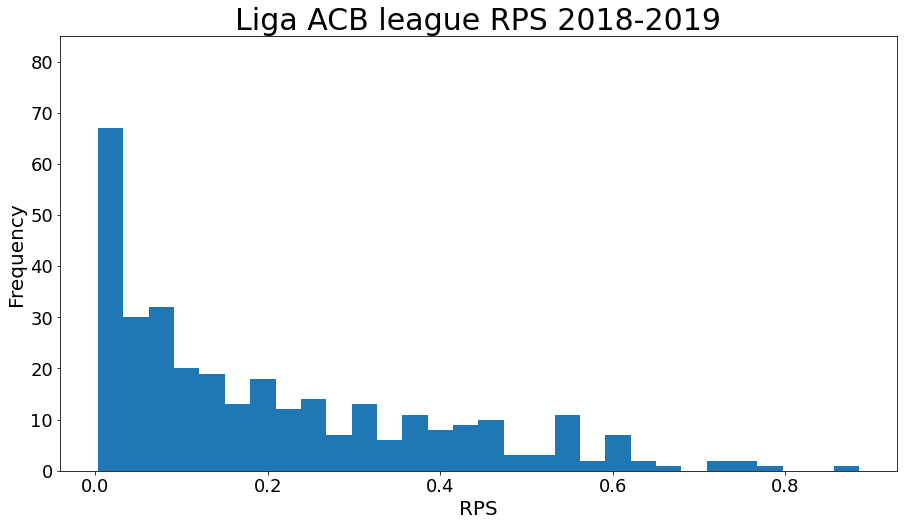

In [38]:
plt.figure(figsize=(15,8))

plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Liga ACB league RPS 2018-2019',fontsize=30)
plt.ylim(0,85)
plt.show()

In [39]:
spain_match_ups = spain_baseline_data[["Home Team","Away Team","Match Date","Winner Team"]][(spain_baseline_data["Match Date"]>'2018-08-01') & (spain_baseline_data["Tournament"]=='Liga ACB') & (spain_baseline_data["Phase"] == "Regular Season")]
spain_match_ups["Probability"] = ens_proba[:len(spain_match_ups)]
spain_match_ups["Winner Prediction"] = np.where(spain_match_ups["Probability"]>0.5,spain_match_ups["Home Team"],spain_match_ups["Away Team"])
spain_match_ups.head()

,Home Team,Away Team,Match Date,Winner Team,Probability,Winner Prediction
1278,FC BARCELONA BÀSQUET,CB GRAN CANARIA,2018-09-27,FC BARCELONA BÀSQUET,0.818712,FC BARCELONA BÀSQUET
1279,BC ANDORRA,UCAM MURCIA CB,2018-09-28,BC ANDORRA,0.639164,BC ANDORRA
1280,BALONCESTO MÁLAGA,VALENCIA BASKET,2018-09-28,BALONCESTO MÁLAGA,0.561444,BALONCESTO MÁLAGA
1281,SASKI BASKONIA,BASKET ZARAGOZA,2018-09-29,SASKI BASKONIA,0.877676,SASKI BASKONIA
1282,OBRADOIRO CAB,CB MIRAFLORES,2018-09-29,OBRADOIRO CAB,0.528293,OBRADOIRO CAB


In [40]:
pd.crosstab(index=spain_match_ups["Winner Prediction"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Prediction,
REAL MADRID BALONCESTO,34
VALENCIA BASKET,28
FC BARCELONA BÀSQUET,28
SASKI BASKONIA,26
BALONCESTO MÁLAGA,22
CB GRAN CANARIA,21
CB 1939 CANARIAS,20
UCAM MURCIA CB,17
CB BREOGÁN,16


In [41]:
pd.crosstab(index=spain_match_ups["Winner Team"], columns="count").sort_values("count",ascending = False)

col_0,count
Winner Team,
REAL MADRID BALONCESTO,28
FC BARCELONA BÀSQUET,27
SASKI BASKONIA,26
VALENCIA BASKET,23
BALONCESTO MÁLAGA,21
CLUB JOVENTUT BADALONA,18
BASKET ZARAGOZA,18
BÀSQUET MANRESA,17
CB 1939 CANARIAS,17


# Euroleague

In [42]:
el_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Euroleague'].reset_index(drop = True)
el_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Euroleague,2014-10-15,SASKI BASKONIA,BC NEPTŪNAS,1,SASKI BASKONIA,Regular Season
1,Euroleague,2014-10-16,VALENCIA BASKET,OLYMPIACOS B.C.,0,OLYMPIACOS B.C.,Regular Season
2,Euroleague,2014-10-16,KK CRVENA ZVEZDA,GALATASARAY S.K. (MEN'S BASKETBALL),1,KK CRVENA ZVEZDA,Regular Season
3,Euroleague,2014-10-16,ANADOLU EFES S.K.,BC UNICS,1,ANADOLU EFES S.K.,Regular Season
4,Euroleague,2014-10-16,KK CEDEVITA JUNIOR,BALONCESTO MÁLAGA,0,BALONCESTO MÁLAGA,Regular Season


In [43]:
el_home = pd.get_dummies(el_baseline_data["Home Team"]).reset_index(drop = True)
el_away = -1*pd.get_dummies(el_baseline_data["Away Team"]).reset_index(drop = True)
el_x = pd.concat([el_home,el_away],axis=1).groupby(level=0, axis=1).sum()
el_y = el_baseline_data["Team Result"]

In [44]:
el_x.head()

,ALBA BERLIN,ANADOLU EFES S.K.,BALONCESTO MÁLAGA,BASKET ZIELONA GÓRA,BC KHIMKI,BC NEPTŪNAS,BC NIZHNY NOVGOROD,BC UNICS,BC ŽALGIRIS,BROSE BAMBERG,CB GRAN CANARIA,DARÜŞŞAFAKA BASKETBOL,DINAMO SASSARI,FC BARCELONA BÀSQUET,FC BAYERN MUNICH (BASKETBALL),FENERBAHÇE BASKETBALL,GALATASARAY S.K. (MEN'S BASKETBALL),KARŞIYAKA BASKET,KK BUDUĆNOST,KK CEDEVITA JUNIOR,KK CRVENA ZVEZDA,LIMOGES,MACCABI TEL AVIV B.C.,OLIMPIA MILANO,OLYMPIACOS B.C.,PANATHINAIKOS B.C.,PBC CSKA MOSCOW,PBC LOKOMOTIV KUBAN,REAL MADRID BALONCESTO,SASKI BASKONIA,SIG STRASBOURG,TURÓW ZGORZELEC,VALENCIA BASKET
0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
x_train_el=el_x.iloc[:len(el_baseline_data[el_baseline_data["Match Date"]<"2018-08-01"])]
y_train_el=el_y.iloc[:len(el_baseline_data[el_baseline_data["Match Date"]<"2018-08-01"])]
x_test_el=el_x.iloc[len(el_baseline_data[el_baseline_data["Match Date"]<"2018-08-01"]):]
y_test_el=el_y.iloc[len(el_baseline_data[el_baseline_data["Match Date"]<"2018-08-01"]):]

###  Logistic Regression

In [46]:
lgr = LogisticRegression(solver='liblinear' , C= 0.7847137962592965, penalty='l1').fit(x_train_el, y_train_el)
y_pre_proba_lgr=lgr.predict_proba(x_test_el)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_el),3))


Logistic Regression

Test BS: 0.2

Test Accuracy: 0.688

Test F1-score: 0.779


In [47]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],el_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()

In [48]:
sorted_coef3.head(50)

,index,0
0,DINAMO SASSARI,-2.073562
1,PBC CSKA MOSCOW,1.751243
2,FENERBAHÇE BASKETBALL,1.369168
3,REAL MADRID BALONCESTO,1.113975
4,TURÓW ZGORZELEC,-1.078463
5,PBC LOKOMOTIV KUBAN,0.967308
6,OLYMPIACOS B.C.,0.950323
7,LIMOGES,-0.720375
8,PANATHINAIKOS B.C.,0.595113
9,SASKI BASKONIA,0.526244


In [49]:
lgr.intercept_

array([0.62205599])

## Random Forest Classifier

In [28]:
rfc = RandomForestClassifier(max_depth= 36, max_features='log2', min_samples_leaf=0.002390948900012013,
                             min_samples_split=0.0096605683266830, n_estimators=73,
                             random_state=1).fit(x_train_el, y_train_el)

y_pre_proba_rfc=rfc.predict_proba(x_test_el)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(y_pre_proba_rfc[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc ,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_el),3))

NameError: name 'x_train_el' is not defined

In [51]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),el_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,PBC CSKA MOSCOW,0.181003
1,FENERBAHÇE BASKETBALL,0.112839
2,REAL MADRID BALONCESTO,0.077903
3,DINAMO SASSARI,0.057436
4,OLIMPIA MILANO,0.046535
5,OLYMPIACOS B.C.,0.043885
6,KK CEDEVITA JUNIOR,0.043000
7,SASKI BASKONIA,0.032772
8,PANATHINAIKOS B.C.,0.032323
9,BC ŽALGIRIS,0.030770


## xgboost

In [52]:
alg = XGBClassifier(colsample_bytree= 0.897167919370632, gamma= 0.835671500072126, learning_rate= 0.3887154858505634,
                    max_depth= 1, n_estimators= 99, reg_lambda= 0.7909237442174416, subsample= 0.963659261900305,
                    objective='binary:logistic').fit(x_train_el, y_train_el)

y_pre_proba_alg=alg.predict_proba(x_test_el)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_el,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(y_pre_proba_alg[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg ,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_el),3))


xgboost

Test BS: 0.197

Test Accuracy: 0.685

Test F1-score: 0.775


In [53]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),el_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,PBC CSKA MOSCOW,0.115066
1,FENERBAHÇE BASKETBALL,0.082748
2,OLIMPIA MILANO,0.072854
3,OLYMPIACOS B.C.,0.068891
4,REAL MADRID BALONCESTO,0.060535
5,KK CEDEVITA JUNIOR,0.052481
6,PANATHINAIKOS B.C.,0.052291
7,DINAMO SASSARI,0.044668
8,BC NIZHNY NOVGOROD,0.043714
9,SASKI BASKONIA,0.035677


In [54]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test RPS:",round(brier_score_loss(y_test_el,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_el),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_el),3))


------Ensemble 3 classifier-------

Test RPS: 0.197

Test Accuracy: 0.696

Test F1-score: 0.782


In [55]:
pd.options.display.max_rows = None
see_final_g=el_baseline_data[["Home Team","Away Team","Team Result"]][el_baseline_data["Match Date"]>"2018-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
1042,OLYMPIACOS B.C.,OLIMPIA MILANO,0,0.833009,0.693904
1051,PANATHINAIKOS B.C.,BC ŽALGIRIS,0,0.771956,0.595916
1089,KK BUDUĆNOST,PBC CSKA MOSCOW,1,0.271298,0.531007
1127,SASKI BASKONIA,FC BARCELONA BÀSQUET,0,0.743780,0.553209
1130,PANATHINAIKOS B.C.,OLIMPIA MILANO,0,0.837503,0.701411
1163,PBC CSKA MOSCOW,MACCABI TEL AVIV B.C.,0,0.902212,0.813986
1177,BC KHIMKI,FC BAYERN MUNICH (BASKETBALL),0,0.734628,0.539678
1180,FC BAYERN MUNICH (BASKETBALL),FENERBAHÇE BASKETBALL,1,0.280918,0.517079
1183,OLYMPIACOS B.C.,FC BARCELONA BÀSQUET,0,0.776865,0.603519
1207,BC KHIMKI,OLIMPIA MILANO,0,0.752776,0.566672


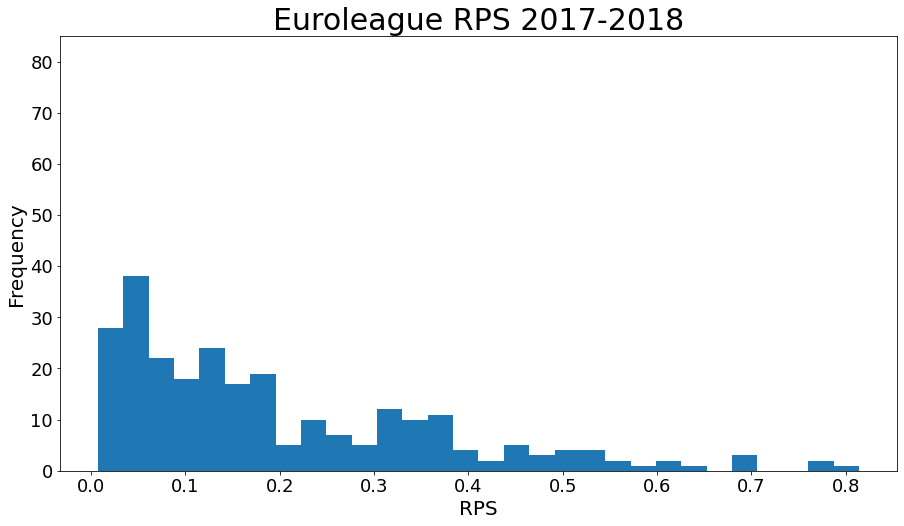

In [56]:
plt.figure(figsize=(15,8))

plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Euroleague RPS 2017-2018',fontsize=30)
plt.ylim(0,85)
plt.show()

# Eurocup

In [57]:
ec_baseline_data = baseline_data[["Tournament","Match Date","Home Team","Away Team","Team Result","Winner Team","Phase"]][baseline_data["Tournament"]=='Eurocup'].reset_index(drop = True)
ec_baseline_data.head()

,Tournament,Match Date,Home Team,Away Team,Team Result,Winner Team,Phase
0,Eurocup,2014-10-14,CB GRAN CANARIA,PALLACANESTRO CANTÙ,1,CB GRAN CANARIA,Regular Season
1,Eurocup,2014-10-14,ARTLAND DRAGONS,ASVEL BASKET,0,ASVEL BASKET,Regular Season
2,Eurocup,2014-10-15,TELEKOM BASKETS BONN,SIG STRASBOURG,0,SIG STRASBOURG,Regular Season
3,Eurocup,2014-10-15,JDA DIJON BASKET,B.C. OOSTENDE,1,JDA DIJON BASKET,Regular Season
4,Eurocup,2014-10-15,KARŞIYAKA BASKET,P.A.O.K. BC,0,P.A.O.K. BC,Regular Season


In [58]:
ec_home = pd.get_dummies(ec_baseline_data["Home Team"]).reset_index(drop = True)
ec_away = -1*pd.get_dummies(ec_baseline_data["Away Team"]).reset_index(drop = True)
ec_x = pd.concat([ec_home,ec_away],axis=1).groupby(level=0, axis=1).sum()
ec_y = ec_baseline_data["Team Result"]

In [59]:
ec_x.head()

,AEK B.C.,ALBA BERLIN,AQUILA BASKET TRENTO,ARIS B.C.,ARKA GDYNIA (BASKETBALL),ARTLAND DRAGONS,AS MONACO BASKET,ASVEL BASKET,AUXILIUM PALLACANESTRO TORINO,B.C. OOSTENDE,BALONCESTO FUENLABRADA,BALONCESTO MÁLAGA,BANDIRMA B.İ.K.,BASKET ZARAGOZA,BASKET ZIELONA GÓRA,BASKETBALL NYMBURK,BASKETS OLDENBURG,BC ANDORRA,BC AVTODOR,BC KHIMKI,BC LIETKABELIS,BC NEPTŪNAS,BC NIZHNY NOVGOROD,BC RYTAS,BC UNICS,BC ZENIT SAINT PETERSBURG,BEŞIKTAŞ J.K. (MEN'S BASKETBALL),BILBAO BASKET,BK VEF RĪGA,BK VENTSPILS,BROSE BAMBERG,CB GRAN CANARIA,CSA STEAUA BUCUREȘTI (BASKETBALL),CSU PLOIEȘTI,DARÜŞŞAFAKA BASKETBOL,DINAMO SASSARI,FC BAYERN MUNICH (BASKETBALL),GALATASARAY S.K. (MEN'S BASKETBALL),HAPOEL JERUSALEM B.C.,JDA DIJON BASKET,KARŞIYAKA BASKET,KK BUDUĆNOST,KK CEDEVITA JUNIOR,KK CRVENA ZVEZDA,KK MORNAR BAR,KK MZT SKOPJE,KK OLIMPIJA,KK PARTIZAN,KRASNY OKTYABR,LE MANS SARTHE BASKET,LIMOGES,MACCABI TEL AVIV B.C.,METROPOLITANS 92,NANTERRE 92,NEW BASKET BRINDISI,OLIMPIA MILANO,P.A.O.K. BC,PALLACANESTRO BRESCIA,PALLACANESTRO CANTÙ,PALLACANESTRO REGGIANA,PBC LOKOMOTIV KUBAN,RATIOPHARM ULM,REAL BETIS BALONCESTO,REYER VENEZIA,RIESEN LUDWIGSBURG,SIG STRASBOURG,SKYLINERS FRANKFURT,SLUC NANCY BASKET,SPIROU CHARLEROI,SZOLNOKI OLAJBÁNYÁSZ,TELEKOM BASKETS BONN,TOFAŞ S.K.,TRABZONSPOR B.K.,TURÓW ZGORZELEC,TÜRK TELEKOM B.K.,UCAM MURCIA CB,VALENCIA BASKET,VIRTUS ROMA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
x_train_ec=ec_x.iloc[:len(ec_baseline_data[ec_baseline_data["Match Date"]<"2018-08-01"])]
y_train_ec=ec_y.iloc[:len(ec_baseline_data[ec_baseline_data["Match Date"]<"2018-08-01"])]
x_test_ec=ec_x.iloc[len(ec_baseline_data[ec_baseline_data["Match Date"]<"2018-08-01"]):]
y_test_ec=ec_y.iloc[len(ec_baseline_data[ec_baseline_data["Match Date"]<"2018-08-01"]):]

###  Logistic Regression

In [61]:
lgr = LogisticRegression(solver='liblinear',C= 0.8479198446641489, penalty= 'l1').fit(x_train_ec, y_train_ec)
y_pre_proba_lgr=lgr.predict_proba(x_test_ec)
print("Logistic Regression")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_lgr[:,1]),3))
print()
y_pre_lgr=np.where(pd.Series(y_pre_proba_lgr[:,1])>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_lgr,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_lgr,y_test_ec),3))


Logistic Regression

Test BS: 0.211

Test Accuracy: 0.64

Test F1-score: 0.729


In [62]:
coef_dict = {}
for coef, feat in zip(lgr.coef_[:].tolist()[0],ec_x.columns.values):
    coef_dict[feat] = coef
coef4=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef4=coef4.iloc[(-coef4[0].abs()).argsort()].reset_index()

In [63]:
sorted_coef4.head(50)

,index,0
0,DARÜŞŞAFAKA BASKETBOL,2.139307
1,PBC LOKOMOTIV KUBAN,1.802692
2,KK MZT SKOPJE,-1.648243
3,FC BAYERN MUNICH (BASKETBALL),1.399623
4,BC KHIMKI,1.349293
5,VALENCIA BASKET,1.337875
6,BK VEF RĪGA,-1.264282
7,NEW BASKET BRINDISI,-1.205271
8,ARTLAND DRAGONS,-1.167732
9,CB GRAN CANARIA,1.116407


In [64]:
lgr.intercept_

array([0.4675072])

## Random Forest Classifier

In [65]:
rfc = RandomForestClassifier(max_depth= 38, max_features='sqrt', min_samples_leaf=0.0037012163422379674,
                             min_samples_split=0.251132570859313, n_estimators=41,
                             random_state=1).fit(x_train_ec, y_train_ec)

y_pre_proba_rfc=rfc.predict_proba(x_test_ec)
print("Random Forest Classifier")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_rfc[:,1]),3))
print()
y_pre_rfc=np.where(y_pre_proba_rfc[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_rfc ,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_rfc,y_test_ec),3))

Random Forest Classifier

Test BS: 0.222

Test Accuracy: 0.651

Test F1-score: 0.747


In [66]:
coef_dict = {}
for coef, feat in zip(rfc.feature_importances_[:].tolist(),ec_x.columns.values):
    coef_dict[feat] = coef
coef2=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef2=coef2.iloc[(-coef2[0].abs()).argsort()].reset_index()
sorted_coef2

,index,0
0,PBC LOKOMOTIV KUBAN,0.113462
1,CB GRAN CANARIA,0.070654
2,FC BAYERN MUNICH (BASKETBALL),0.054147
3,VALENCIA BASKET,0.044924
4,BC KHIMKI,0.041409
5,DARÜŞŞAFAKA BASKETBOL,0.040165
6,BC UNICS,0.039921
7,BILBAO BASKET,0.035753
8,KRASNY OKTYABR,0.032373
9,BASKET ZIELONA GÓRA,0.031401


## xgboost

In [67]:
alg = XGBClassifier(colsample_bytree= 0.5913621206231853, gamma= 4.08026456094463, learning_rate= 0.37903160103981465,
                    max_depth= 47, n_estimators= 94, reg_lambda= 0.11419103539605524, subsample= 0.7917278647223511,
                    objective='binary:logistic').fit(x_train_ec, y_train_ec)

y_pre_proba_alg=alg.predict_proba(x_test_ec)
print("xgboost")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,y_pre_proba_alg[:,1]),3))
print()
y_pre_alg=np.where(y_pre_proba_alg[:,1] > 0.5, 1, 0)
print("Test Accuracy:",round(accuracy_score(y_pre_alg ,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_alg,y_test_ec),3))


xgboost

Test BS: 0.219

Test Accuracy: 0.683

Test F1-score: 0.779


In [68]:
coef_dict = {}
for coef, feat in zip(alg.feature_importances_[:].tolist(),ec_x.columns.values):
    coef_dict[feat] = coef
coef3=pd.DataFrame.from_dict(coef_dict,orient ='index')
sorted_coef3=coef3.iloc[(-coef3[0].abs()).argsort()].reset_index()
sorted_coef3

,index,0
0,PBC LOKOMOTIV KUBAN,0.049883
1,BC LIETKABELIS,0.047736
2,ARTLAND DRAGONS,0.041690
3,FC BAYERN MUNICH (BASKETBALL),0.040152
4,BALONCESTO MÁLAGA,0.039667
5,BC UNICS,0.036584
6,CB GRAN CANARIA,0.036441
7,RATIOPHARM ULM,0.035431
8,KK BUDUĆNOST,0.034693
9,KRASNY OKTYABR,0.034107


In [69]:
ens_proba=(y_pre_proba_lgr[:,1]+y_pre_proba_rfc[:,1]+y_pre_proba_alg[:,1])/3


print("------Ensemble 3 classifier-------")
print()
print("Test BS:",round(brier_score_loss(y_test_ec,ens_proba),3))
print()
y_pre_ens=np.where(pd.Series(ens_proba)>0.5,1,0)
print("Test Accuracy:",round(accuracy_score(y_pre_ens,y_test_ec),3))
print()
print("Test F1-score:",round(f1_score(y_pre_ens,y_test_ec),3))


------Ensemble 3 classifier-------

Test BS: 0.215

Test Accuracy: 0.667

Test F1-score: 0.762


In [70]:
pd.options.display.max_rows = None
see_final_g=ec_baseline_data[["Home Team","Away Team","Team Result"]][ec_baseline_data["Match Date"]>"2018-08-01"]
see_final_g["prediction probability"]=ens_proba
see_final_g["RPS"]=(see_final_g["Team Result"]-see_final_g["prediction probability"])**2
see_final_g[see_final_g["RPS"]>0.5]

,Home Team,Away Team,Team Result,prediction probability,RPS
954,KK PARTIZAN,BC ZENIT SAINT PETERSBURG,1,0.289714,0.504506
994,PBC LOKOMOTIV KUBAN,ALBA BERLIN,0,0.829592,0.688222
1041,ASVEL BASKET,KK PARTIZAN,0,0.768291,0.590271
1061,PALLACANESTRO BRESCIA,RATIOPHARM ULM,0,0.752027,0.565544
1066,PBC LOKOMOTIV KUBAN,ASVEL BASKET,0,0.821892,0.675506
1079,BC ZENIT SAINT PETERSBURG,BC ANDORRA,0,0.708291,0.501676
1087,AS MONACO BASKET,KK PARTIZAN,0,0.770665,0.593924
1100,ASVEL BASKET,PBC LOKOMOTIV KUBAN,1,0.202447,0.636091
1101,SKYLINERS FRANKFURT,RATIOPHARM ULM,0,0.752027,0.565544
1113,BC UNICS,PBC LOKOMOTIV KUBAN,1,0.271461,0.530769


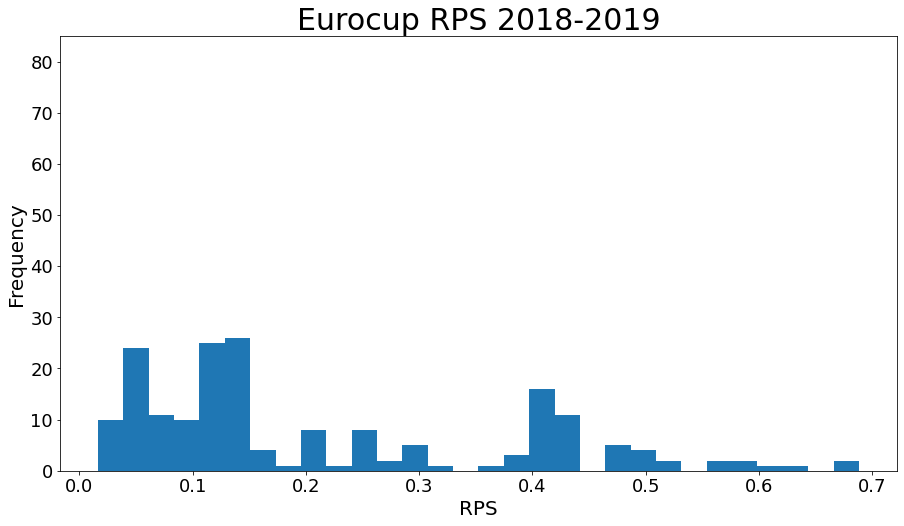

In [71]:
plt.figure(figsize=(15,8))



plt.hist(see_final_g["RPS"], 30, density=0)

plt.xlabel('RPS',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Eurocup RPS 2018-2019',fontsize=30)
plt.ylim(0,85)
plt.show()